In [7]:
# LSTM Input Preparation
# 이 노트북은 merged_energy.parquet 파일을 기반으로
# 특정 건물 + 측정 항목에 대해 LSTM 입력을 준비합니다.
# - 로그 변환 제거
# - 극단값 필터링
# - StandardScaler 적용 및 저장

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
import os

# 1. Load merged dataset
df = pd.read_parquet("../data/processed/merged_energy.parquet")
print("Shape:", df.shape)
df.head()

Shape: (67455298, 5)


,building_id,meter_type,timestamp,value,source
0,0,0,2016-01-01,0.0,ASHRAE
1,1,0,2016-01-01,0.0,ASHRAE
2,2,0,2016-01-01,0.0,ASHRAE
3,3,0,2016-01-01,0.0,ASHRAE
4,4,0,2016-01-01,0.0,ASHRAE


In [8]:
# 2. Filter for specific meter_type and building_id
# 예: 전기 데이터, building_id == '1'

# print("meter_type:", df['meter_type'].unique())
# print("building_id (electricity만):")
# print(df[df['meter_type'] == 'electricity']['building_id'].value_counts().head(10))

df_filtered = df[
    (df['meter_type'] == 'electricity') &
    (df['building_id'] == 'Lamb_office_Jo')
][['timestamp', 'value']].copy()

df_filtered = df_filtered.sort_values('timestamp')
df_filtered.set_index('timestamp', inplace=True)

# 1시간 단위로 리샘플링하고 결측값 보간(interpolation)
df_filtered = df_filtered.resample('1h').mean()

# 결측률 확인
missing_ratio = df_filtered['value'].isna().mean()
print("Missing ratio after resample: {:.2f}%".format(missing_ratio * 100))

df_filtered['value'] = df_filtered['value'].interpolate()
df_filtered = df_filtered[df_filtered['value'] > 1e-3]  # 필요시 조정

# 로그 변환 후 정규화 (without log)
# df_filtered['value_log'] = np.log1p(df_filtered['value'])  # log(1 + x)
scaler = StandardScaler()
df_filtered['value_scaled'] = scaler.fit_transform(df_filtered[['value']])
print("value min/max:", df_filtered['value'].min(), df_filtered['value'].max())
print("scaled min/max:", df_filtered['value_scaled'].min(), df_filtered['value_scaled'].max())

df_filtered.head()

Missing ratio after resample: 0.00%
value min/max: 0.003 21.9
scaled min/max: -0.9790173410202515 9.797861366594724


,value,value_scaled
timestamp,,
2016-01-01 00:00:00,1.1,-0.439115
2016-01-01 01:00:00,2.1,0.053047
2016-01-01 02:00:00,2.0,0.003831
2016-01-01 03:00:00,2.5,0.249912
2016-01-01 04:00:00,2.0,0.003831


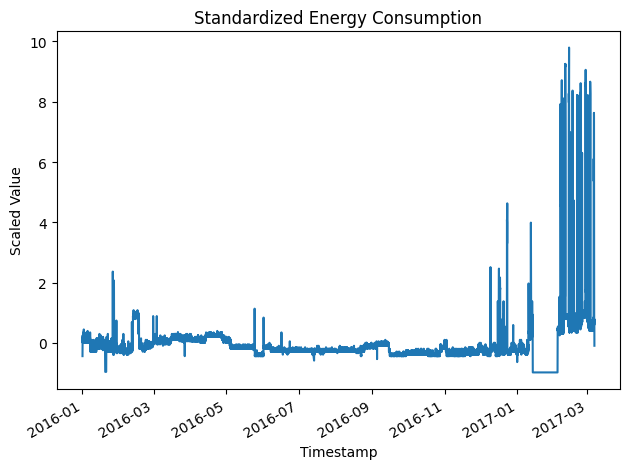

In [9]:

# 시각화
df_filtered['value_scaled'].plot(title='Standardized Energy Consumption')
plt.xlabel("Timestamp")
plt.ylabel("Scaled Value")
plt.tight_layout()
plt.show()


In [10]:
# 4. Create sliding window sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 24  # 과거 24시간을 보고 1시간 예측
X, y = create_sequences(df_filtered['value_scaled'].values, window_size)
print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)


Input shape (X): (9931, 24)
Target shape (y): (9931,)


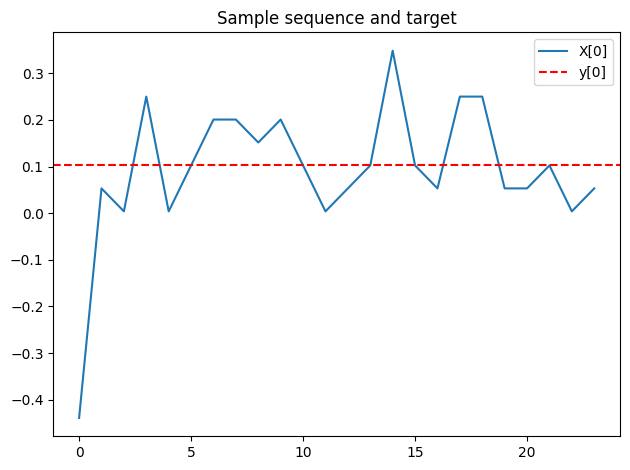

In [11]:
# 5. Preview sample sequence
plt.plot(X[0], label="X[0]")
plt.axhline(y=y[0], color='red', linestyle='--', label="y[0]")
plt.title("Sample sequence and target")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# 6. Save processed LSTM input sequences
os.makedirs("../data/processed", exist_ok=True)
np.save("../data/processed/X_lstm.npy", X.astype(np.float32))
np.save("../data/processed/y_lstm.npy", y.astype(np.float32))
print("Saved to ../data/processed/X_lstm.npy and y_lstm.npy")

# 10. Save scaler
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/standard_scaler.pkl")
print("Scaler saved to models/standard_scaler.pkl")

Saved to ../data/processed/X_lstm.npy and y_lstm.npy
Scaler saved to models/standard_scaler.pkl
